##  ewf-ext-02-03-01 - Landsat-7 and -8 NDVI time series

Landsat-7 and -8 NDVI time series

### <a name="service">Service Definition

In [61]:
service = dict([('title', 'Landsat-7 and -8 NDVI time series'),
                ('abstract', 'Landsat-7 and -8 NDVI time series'),
                ('id', 'ewf-ext-02-03-01')])

### <a name="parameter">Parameter Definition 

In [62]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

In [63]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'Leziria'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifier**

This is the Sentinel-2 product identifier

In [64]:
#input_identifier = 'LE07_L1TP_204033_20171130_20171226_01_T1'

**Input reference**

This is the Landsat-7 (espa-sr) catalogue reference

In [65]:
input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20171114_20171210_01_T1'

**Data path**

This path defines where the data is staged-in. 

In [66]:
#data_path = '/workspace/data'

###  Aux folders

In [67]:
output_folder = ''

In [68]:
temp_folder = 'temp'

### <a name="workflow">Workflow

#### Import the packages required for processing the Landsat vegetation indices

In [69]:
import os
import sys

from urlparse import urlparse

from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.wkt import loads
from shapely.geometry import box
import cioppy
import lxml.etree as etree
#import gdal
#import osr

#import numpy as np
from osgeo import gdal, ogr, osr

import numpy as np
from geopandas import GeoDataFrame
import pandas as pd
import geopandas as gp


ciop = cioppy.Cioppy()

###  Auxiliary vars

In [70]:
check_results = True

###  Auxiliary methods

In [71]:
 # remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

###   Auxiliary folders

In [72]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

### Define the AOI

In [73]:

#point_of_interest = Point(-9.189, 38.733)
#point_of_interest = Point(-8.914205, 38.936165)


In [74]:
#buffer_size = 0.05

In [75]:
#aoi_wkt = box(*point_of_interest.buffer(buffer_size).bounds)

aoi_wkt = loads(regionOfInterest['value'])

In [76]:
aoi_wkt.wkt

'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'

In [77]:
bbox = list(aoi_wkt.bounds)
bbox

[-8.964205000000002, 38.88616500000001, -8.864205, 38.986165]

In [78]:
def eop_metadata(metadata):

    opt = 'http://www.opengis.net/opt/2.1'
    om  = 'http://www.opengis.net/om/2.0'
    gml = 'http://www.opengis.net/gml/3.2'
    eop = 'http://www.opengis.net/eop/2.1'
    sar = 'http://www.opengis.net/sar/2.1'
    
    root = etree.Element('{%s}EarthObservation' % opt)

    phenomenon_time = etree.SubElement(root, '{%s}phenomenonTime' % om)

    time_period = etree.SubElement(phenomenon_time, '{%s}TimePeriod' % gml)

    begin_position = etree.SubElement(time_period, '{%s}beginPosition'  % gml)

    end_position = etree.SubElement(time_period, '{%s}endPosition'  % gml)

    procedure = etree.SubElement(root, '{%s}procedure' % om)

    earth_observation_equipment = etree.SubElement(procedure, '{%s}EarthObservationEquipment' % eop)

    acquisition_parameters = etree.SubElement(earth_observation_equipment, '{%s}acquisitionParameters' % eop)

    acquisition = etree.SubElement(acquisition_parameters, '{%s}Acquisition' % sar)

    orbit_number = etree.SubElement(acquisition, '{%s}orbitNumber' % eop)

    wrs_longitude_grid = etree.SubElement(acquisition, '{%s}wrsLongitudeGrid' % eop)

    wrs_latitude_grid = etree.SubElement(acquisition, '{%s}wrsLatitudeGrid' % eop)
    
    
    feature_of_interest = etree.SubElement(root, '{%s}featureOfInterest' % om)
    footprint = etree.SubElement(feature_of_interest, '{%s}Footprint' % eop)
    multi_extentOf = etree.SubElement(footprint, '{%s}multiExtentOf' % eop)
    multi_surface = etree.SubElement(multi_extentOf, '{%s}MultiSurface' % gml)
    surface_members = etree.SubElement(multi_surface, '{%s}surfaceMembers' % gml)
    polygon = etree.SubElement(surface_members, '{%s}Polygon' % gml)    
    exterior = etree.SubElement(polygon, '{%s}exterior' % gml)  
    linear_ring = etree.SubElement(exterior, '{%s}LinearRing' % gml) 
    poslist = etree.SubElement(linear_ring, '{%s}posList' % gml) 


    result = etree.SubElement(root, '{%s}result' % om)
    earth_observation_result = etree.SubElement(result, '{%s}EarthObservationResult' % opt)
    cloud_cover_percentage = etree.SubElement(earth_observation_result, '{%s}cloudCoverPercentage' % opt)
    
    metadata_property = etree.SubElement(root, '{%s}metaDataProperty' % eop)
    earth_observation_metadata = etree.SubElement(metadata_property, '{%s}EarthObservationMetaData' % eop)
    identifier = etree.SubElement(earth_observation_metadata, '{%s}identifier' % eop)
    
    begin_position.text = metadata['startdate']
    end_position.text = metadata['enddate']
    orbit_number.text = metadata['orbitNumber']
    wrs_longitude_grid.text = metadata['wrsLongitudeGrid']
    wrs_latitude_grid.text = metadata['wrsLatitudeGrid']
    
    coords = np.asarray([t[::-1] for t in list(loads(metadata['wkt']).exterior.coords)]).tolist()
 
    pos_list = ''
    for elem in coords:
        pos_list += ' '.join(str(e) for e in elem) + ' '   

    poslist.attrib['count'] = str(len(coords))
    poslist.text = pos_list
    
    
    identifier.text = metadata['identifier']

    return etree.tostring(root, pretty_print=True)

#### Get the metadata of the Landsat 7 product

In [79]:
#ciop = cioppy.Cioppy()

temp_results = []

search_params = dict()

search_params['do'] = 'terradue'

ls7_catalogue_metadata = ciop.search(end_point=input_reference,
                                     params=[],
                                     output_fields='enclosure,identifier,startdate,enddate,wkt,orbitNumber,swathIdentifier,wrsLongitudeGrid,wrsLatitudeGrid',
                                     model='EOP')[0]


In [80]:
ls7_catalogue_metadata

{'enclosure': 'https://store.terradue.com/espa-sr/2017/11/14/files/v1/LE07_L1TP_204033_20171114_20171210_01_T1_SR.tif',
 'enddate': '2017-11-14T11:17:20.2610000Z',
 'identifier': 'LE07_L1TP_204033_20171114_20171210_01_T1',
 'orbitNumber': '',
 'startdate': '2017-11-14T11:16:53.5070000Z',
 'swathIdentifier': '',
 'wkt': 'POLYGON((-10.28179 38.25103,-8.13622 37.93978,-7.61909 39.53646,-9.81268 39.85478,-10.28179 38.25103))',
 'wrsLatitudeGrid': '',
 'wrsLongitudeGrid': ''}

### Get the Landsat 7 product bands (geotiff)

* Get the download url
* Extract the needed bands cropping them with respect to the defined AOI

In [81]:
ls7_tif_url = ls7_catalogue_metadata['enclosure']

print ls7_tif_url

https://store.terradue.com/espa-sr/2017/11/14/files/v1/LE07_L1TP_204033_20171114_20171210_01_T1_SR.tif


In [82]:
def get_bands_geotiff(download_url, band_indices, crop=False, bbox=None):
    
    
    output = '/vsimem/clip.tif'
    
    parsed_url = urlparse(download_url)
    url = '%s://%s/api%s' % (list(parsed_url)[0], list(parsed_url)[1], list(parsed_url)[2])
    
    gdal.UseExceptions()
    gdal.SetConfigOption("GDAL_DISABLE_READDIR_ON_OPEN","YES")
    gdal.SetConfigOption("CPL_VSIL_CURL_ALLOWED_EXTENSIONS","tif")
    
    try:    
        ds = gdal.Open('/vsicurl/%s' % url)
        
    except Exception as e:
        print e
        raise
        
    if crop == True:
        print 'Cropping data...'
        ulx, uly, lrx, lry = bbox[0], bbox[3], bbox[2], bbox[1]
        ds = gdal.Translate(output, ds, bandList=band_indices, projWin = [ulx, uly, lrx, lry], projWinSRS = 'EPSG:4326')
        print 'data cropping : DONE'
        
    else:    
        ds = gdal.Translate(output, ds, bandList=band_indices)
        
    ds = None
    ds = gdal.Open(output)
    w = ds.GetRasterBand(1).XSize
    h = ds.GetRasterBand(1).YSize
    geo_transform = ds.GetGeoTransform()
    projection = ds.GetProjection()

    for i,b in enumerate(band_indices):
        
        out_name = '%s_SR_B%s.TIF' % (ls7_catalogue_metadata['identifier'], str(b))
        
        out_name = '/'.join([temp_folder, out_name])
        
        print 'creating %s' %out_name
        
        data = ds.GetRasterBand(i+1).ReadAsArray(0, 0, w, h).astype(np.float32)
        
        bmin = data[data!=-9999].min()
        bmax = data[data!=-9999].max()
        #Let's map the data into [0.0, 1.0]
        if bmin != bmax:
            data[data!= -9999] = (data[data!=-9999] - bmin)/(bmax - bmin)
        else:
            data[data!=-9999] = 1.0
        

    
        drv = gdal.GetDriverByName('GTiff')

        ds2 = drv.Create(out_name, w, h, 1, gdal.GDT_Float32)

        ds2.SetGeoTransform(geo_transform)
        ds2.SetProjection(projection)

        ds2.GetRasterBand(1).WriteArray(data, 0, 0)
        ds2.FlushCache()

    
    ds = None
    ds2=None
    
    return

##### Landsat7 NDVI is computed with band3 and band4: (b4 - b3)/(b4 + b3)

In [83]:
band_1 = 4
band_2 = 3

band_1_name = '%s_SR_B%s.TIF' % (ls7_catalogue_metadata['identifier'], str(band_1))
band_2_name = '%s_SR_B%s.TIF' % (ls7_catalogue_metadata['identifier'], str(band_2))

band_1_name = '/'.join([temp_folder, band_1_name])
band_2_name = '/'.join([temp_folder, band_2_name])


ciop.log("INFO", "Getting and cropping Landsat bands 3 and 4")

get_bands_geotiff(ls7_tif_url, [band_2,band_1], crop=True, bbox=bbox)


reporter:status:2019-08-30T17:19:47.748714 [INFO   ] [user process] Getting and cropping Landsat bands 3 and 4
2019-08-30T17:19:47.748714 [INFO   ] [user process] Getting and cropping Landsat bands 3 and 4


Cropping data...
data cropping : DONE
creating temp/LE07_L1TP_204033_20171114_20171210_01_T1_SR_B3.TIF
creating temp/LE07_L1TP_204033_20171114_20171210_01_T1_SR_B4.TIF


#### Compute the vegetation index with OTB tools

In [84]:
def get_wkt(geotiff):


    src = gdal.Open(geotiff)
    
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()

    max_x = ulx + (src.RasterXSize * xres)
    min_y = uly + (src.RasterYSize * yres)
    min_x = ulx 
    max_y = uly
    
    source = osr.SpatialReference()
    
    source.ImportFromWkt(src.GetProjection())

    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)

    transform = osr.CoordinateTransformation(source, target)

    a = transform.TransformPoint(min_x, min_y)
    
    wkt_out = box(transform.TransformPoint(min_x, min_y)[0],
                    transform.TransformPoint(min_x, min_y)[1],
                    transform.TransformPoint(max_x, max_y)[0],
                    transform.TransformPoint(max_x, max_y)[1]).wkt
    
    
    return wkt_out

In [85]:
def get_ndvi (b1, b2):
    
    ndvi = -9999
    
    if b1 >= 0 and b1 <= 1 and b2 >= 0 and b2 <= 1:
        ndvi = ( b1 - b2 ) / ( b1 + b2 )
    
    return ndvi


def load_img_to_matrix (img_path):
    
    dataset = gdal.Open(img_path)
    product_array = dataset.GetRasterBand(1).ReadAsArray()
    return product_array



def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type



def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)
    


def normalized_difference(band_1, band_2, metadata, output_name):

    metadata_name = '{0}.xml'.format(output_name)
    
    #otb_app = otbApplication.Registry.CreateApplication('BandMath')
    
    #otb_app.SetParameterStringList('il', [band_1, band_2])

    #otb_app.SetParameterString('out', '{0}.TIF'.format(output_name))
    
    #otb_app.SetParameterString('exp', 'im1b1 >= 0 && im1b1 <= 1 && im2b1 >= 0 && im2b1 <= 1 ? ( im1b1 - im2b1 ) / ( im1b1 + im2b1 ) : -9999 ')

    #otb_app.ExecuteAndWriteOutput()
    
    
    mat_band_1 = load_img_to_matrix(band_1)
    mat_band_2 = load_img_to_matrix(band_2)
    
    
    ndvi_calculator = np.vectorize(get_ndvi)
    
    mat_ndvi = ndvi_calculator(mat_band_1, mat_band_2)
    
    
    projection, geotransform, no_data_value, data_type = get_metadata(band_1)
    
    no_data_value = -9999

    write_output_image(output_name + '.TIF', mat_ndvi, 'GTiff', data_type, None, projection, geotransform, no_data_value)
    
  
    
    
    #Set the actual wkt for NDVI 
    metadata['wkt'] = get_wkt('{0}.TIF'.format(output_name))
    
    metadata['identifier'] = output_name
    
    return True

In [86]:
output_name = '{0}_SR_{1}'.format(ls7_catalogue_metadata['identifier'],'NDVI')



ciop.log("INFO", "Computing NDVI")

normalized_difference(band_1_name,
                      band_2_name,
                      ls7_catalogue_metadata,
                      output_name)

new_identifier = ls7_catalogue_metadata['identifier']
metadata_name = '{0}.xml'.format(new_identifier)

with open(metadata_name, 'wb') as file:
    file.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    file.write(eop_metadata(ls7_catalogue_metadata)) 


reporter:status:2019-08-30T17:19:48.922564 [INFO   ] [user process] Computing NDVI
2019-08-30T17:19:48.922564 [INFO   ] [user process] Computing NDVI


In [87]:
output_name

'LE07_L1TP_204033_20171114_20171210_01_T1_SR_NDVI'

### <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.

## Check results

In [88]:
if check_results:
    import matplotlib
    import matplotlib.pyplot as plt
    from PIL import Image
    %matplotlib inline


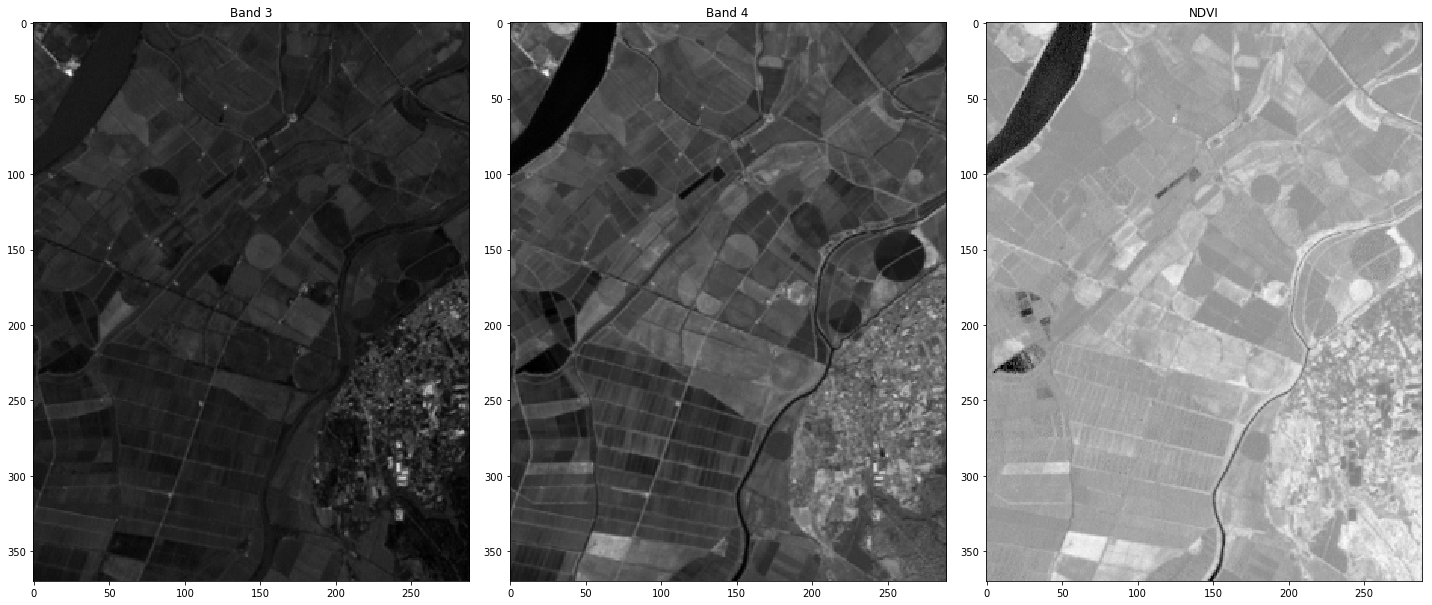

In [89]:
if check_results:
    
    ds = gdal.Open(band_1_name)
    band4 = ds.GetRasterBand(1).ReadAsArray()
    ds=None

    ds = gdal.Open(band_2_name)
    band3 = ds.GetRasterBand(1).ReadAsArray()
    ds=None

    ds = gdal.Open('{0}.TIF'.format(output_name))
    ndvi = ds.GetRasterBand(1).ReadAsArray()
    ds=None

    for b in [band3, band4, ndvi]:

        bmin = b[b!=-9999].min()
        bmax =  b[b!=-9999].max()
        
        if bmin != bmax:    
            b[b!=-9999] = (b[b!=-9999] - bmin)/(bmax - bmin) * 255
  
        b[b==-9999]=np.nan

    fig = plt.figure(figsize=(20,20))

    a = fig.add_subplot(1,3,1)
    imgplot = plt.imshow(band3.astype(np.uint8),cmap='gray')
    a.set_title('Band 3')

    a = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(band4.astype(np.uint8),cmap='gray')
    a.set_title('Band 4')

    a = fig.add_subplot(1,3,3)
    imgplot = plt.imshow(ndvi.astype(np.uint8),cmap='gray')
    a.set_title('NDVI')

    plt.tight_layout()
    fig = plt.gcf()
    plt.show()

    fig.clf()
    plt.close()


### Remove temporay files and folders

In [90]:
ciop.log("INFO", "Removing aux data")

rm_cfolder(temp_folder)

os.rmdir(temp_folder)

reporter:status:2019-08-30T17:20:05.996708 [INFO   ] [user process] Removing aux data
2019-08-30T17:20:05.996708 [INFO   ] [user process] Removing aux data
